In [ ]:
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from torch.nn.parallel import DataParallel
import torch.nn.functional as F
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 新数据
# 读取所有数据
paths = [
    './data/clean/clean_processed_data_1500_1.csv', './data/clean/clean_processed_data_1500_2.csv', './data/clean/clean_processed_data_1500_3.csv',
    './data/clean/clean_processed_data_1500_4.csv', './data/clean/clean_processed_data_1500_5.csv', './data/clean/clean_processed_data_1500_6.csv',
    './data/new1/clean_processed_data_1500_1.csv', './data/new1/clean_processed_data_1500_2.csv', './data/new1/clean_processed_data_1500_3.csv',
    './data/new1/clean_processed_data_1500_4.csv', './data/new1/clean_processed_data_1500_5.csv', './data/new1/clean_processed_data_1500_6.csv',
    './data/new2/clean_processed_data_1500_1.csv', './data/new2/clean_processed_data_1500_2.csv', './data/new2/clean_processed_data_1500_3.csv',
    './data/new2/clean_processed_data_1500_4.csv', './data/new2/clean_processed_data_1500_5.csv', './data/new2/clean_processed_data_1500_6.csv',
    './data/new3/clean_processed_data_1500_1.csv', './data/new3/clean_processed_data_1500_2.csv', './data/new3/clean_processed_data_1500_3.csv',
    './data/new3/clean_processed_data_1500_4.csv', './data/new3/clean_processed_data_1500_5.csv', './data/new3/clean_processed_data_1500_6.csv'   
]

all_data = []
for path in paths:
    data = pd.read_csv(path,header=None)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data) 
processed = np.array(processed, dtype=object)
print(processed.shape)
print(processed[3][:5])

(10632,)
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO3' '2']
 ['MoO2' '96']
 ['MoO2S2' '2']]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import seaborn as sns
import re

def molecule_size(formula: str) -> int:
    """
    根据分子式计算节点大小，方法是提取其中所有数字并求和。
    例如: "Mo3O9S2" -> 3+9+2 = 14
    如果没有数字，就返回 1。
    """
    numbers = re.findall(r'\d+', formula)
    if numbers:
        return sum(int(n) for n in numbers)*8+16
    else:
        return 16


def show_molecule_graph(G, src_img_path=None, mask_path=None):
    # 如果有背景图像
    if src_img_path and mask_path:
        src_img = cv2.imread(src_img_path)
        mask_img = cv2.imread(mask_path)
        if src_img is not None and mask_img is not None:
            mask_h, mask_w, _ = mask_img.shape
            src_img_resized = cv2.resize(src_img, (mask_w, mask_h))
            src_img_adjusted = cv2.convertScaleAbs(src_img_resized, alpha=0.5, beta=100)
        else:
            print("Error: Could not load source image or mask image.")
            return
    else:
        src_img_adjusted = None

    # figure
    fig, ax = plt.subplots(figsize=(10, 8))
    if src_img_adjusted is not None:
        ax.imshow(cv2.cvtColor(src_img_adjusted, cv2.COLOR_BGR2RGB))

    # --- 节点大小由分子式决定 ---
    node_sizes = [300 + 50 * molecule_size(node) for node in G.nodes()]

    # 🎨 使用sci常见的colorblind-friendly调色板
    palette = sns.color_palette("colorblind", n_colors=len(G))
    node_colors = [palette[i % len(palette)] for i in range(len(G))]

    pos = nx.spring_layout(G, seed=43,k=0.6)
    # pos = nx.kamada_kawai_layout(G)
    # pos = nx.spectral_layout(G)
    # pos = nx.random_layout(G)
    for node in pos:
        pos[node] = pos[node] * 0.1

    # --- 画节点，带黑色窄边框 ---
    nx.draw_networkx_nodes(
        G, pos=pos,
        node_size=node_sizes,
        node_color=node_colors,
        edgecolors="black", linewidths=0.5,  # 黑色窄边框
        ax=ax
    )

    # --- 边改为浅灰色 ---
    edges = nx.draw_networkx_edges(
        G, pos=pos,
        arrowstyle="->", arrowsize=1,
        edge_color="gray", width=2,
        connectionstyle="arc3,rad=0.1",
        ax=ax,alpha=0.3
    )

    # --- 标签 ---
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="white",font_weight='bold')

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


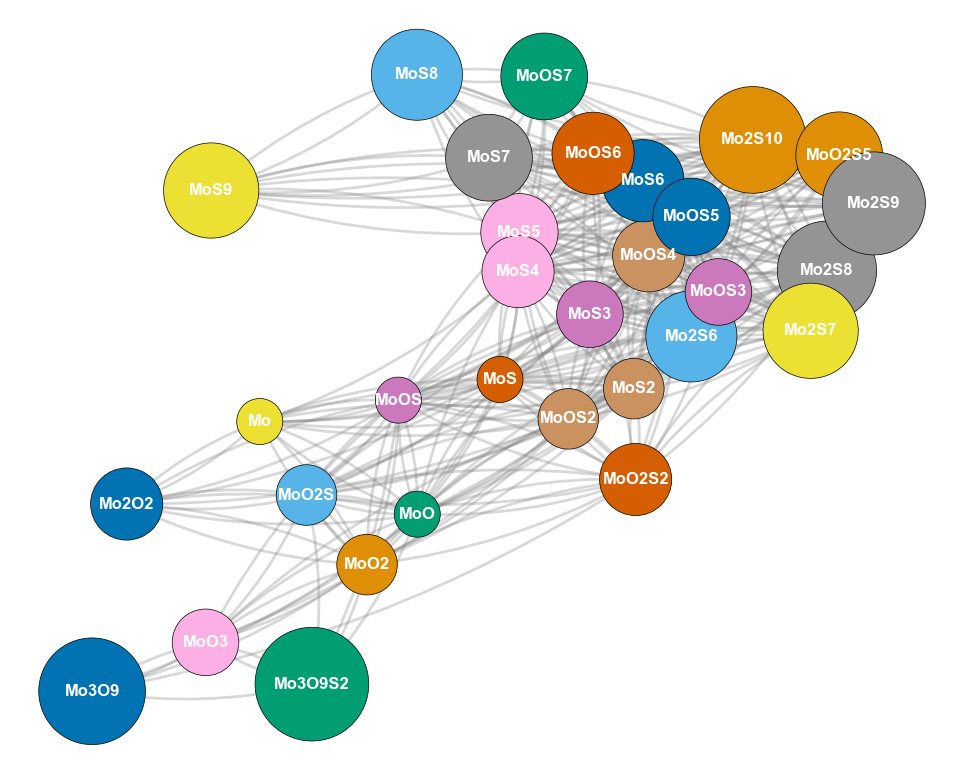

In [119]:
def build_molecule_graph(processed):
    G = nx.DiGraph()
    for path in processed:
        # path 是 Nx2 的数组，第一列是分子式
        molecules = path[:, 0]
        for i in range(len(molecules) - 1):
            G.add_edge(molecules[i], molecules[i+1])
    return G

# 从 processed 构建大图
G = build_molecule_graph(processed[:166])

show_molecule_graph(G)

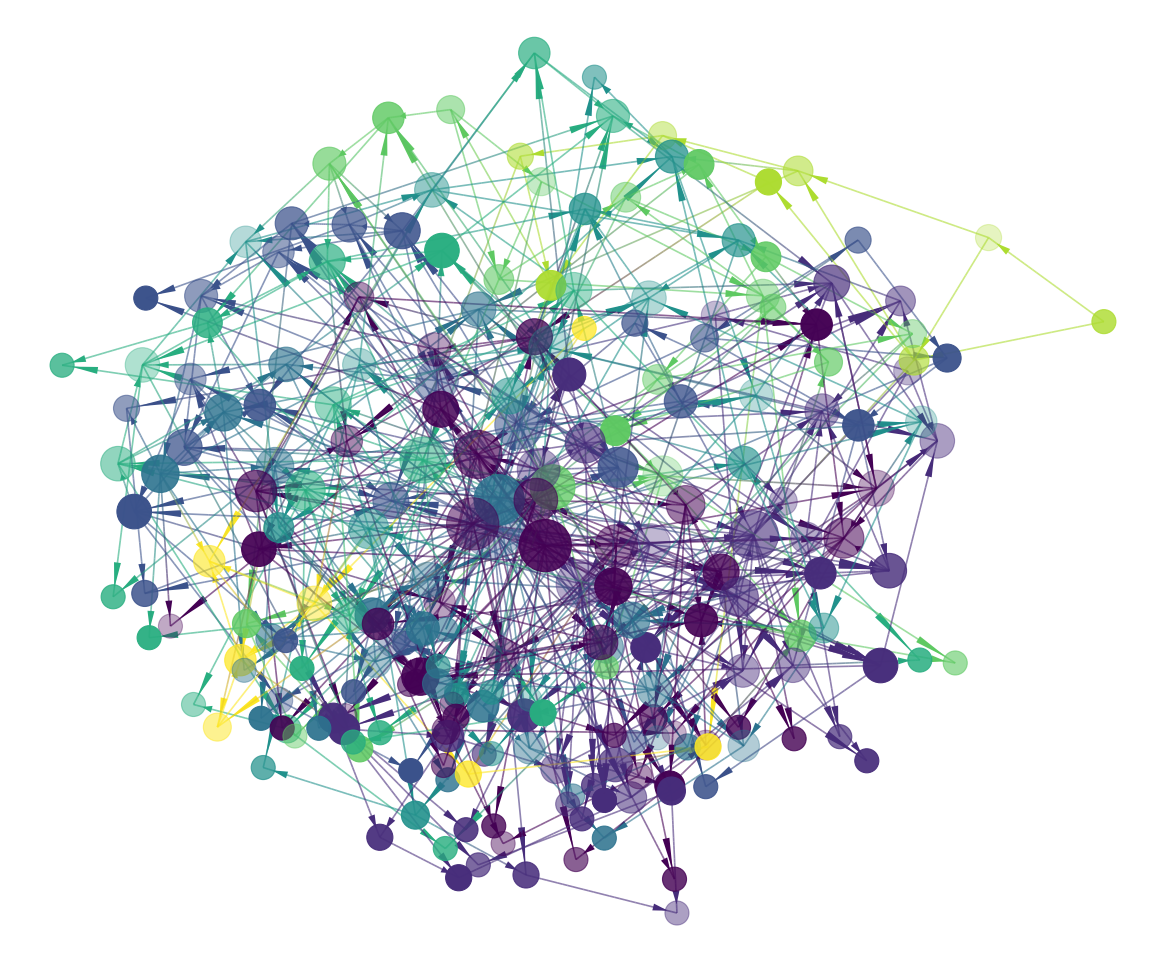

In [178]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch

# --------------------------
# 1. 生成有向图
# --------------------------
G1 = nx.watts_strogatz_graph(n=150, k=4, p=0.3)
G2 = nx.barabasi_albert_graph(n=200, m=2)
G2 = nx.relabel_nodes(G2, lambda x: x + 30)
G_undirected = nx.compose(G1, G2)

G = nx.DiGraph()
G.add_edges_from(G_undirected.edges())
for _ in range(10):
    u, v = np.random.choice(list(G.nodes), 2, replace=False)
    G.add_edge(u, v)

# --------------------------
# 2. 布局
# --------------------------
pos = nx.kamada_kawai_layout(G)

# --------------------------
# 3. 节点属性
# --------------------------
min_size, max_size = 300, 2000
degrees = np.array([G.degree(n) for n in G.nodes()])
node_sizes = min_size + (degrees - degrees.min())/(degrees.max()-degrees.min())*(max_size-min_size)

communities = list(community.greedy_modularity_communities(G.to_undirected()))
colors = plt.cm.viridis(np.linspace(0, 1, len(communities)))
node_color_map = {node: colors[i]
                  for i, com in enumerate(communities) for node in com}

node_colors = []
alphas = np.random.uniform(0.3, 1.0, size=len(G.nodes()))
for i, n in enumerate(G.nodes()):
    base = node_color_map[n]
    node_colors.append((*base[:3], alphas[i]))

# --------------------------
# 4. 辅助函数：计算节点半径(坐标单位)
# --------------------------
def calc_node_radius(node_size, ax):
    """
    将 node_size (点^2) 转换为布局坐标下的半径
    """
    # node_size 是面积(点^2)
    # 直径 (点) = 2 * sqrt(area/pi)
    diameter_pts = 2 * np.sqrt(node_size / np.pi)
    # 将点转换为轴坐标单位
    fig = ax.figure
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width_in, height_in = bbox.width, bbox.height
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    x_scale = (x_range[1] - x_range[0]) / (fig.dpi * width_in)
    y_scale = (y_range[1] - y_range[0]) / (fig.dpi * height_in)
    # 取平均缩放，假设各向同性
    scale = (x_scale + y_scale) / 2.0
    return (diameter_pts/2) * scale

# --------------------------
# 5. 绘图
# --------------------------
fig, ax = plt.subplots(figsize=(12, 10))

# 渐变边
def gradient_line(ax, p1, p2, c1, c2, n=30, lw=1.2):
    xs = np.linspace(p1[0], p2[0], n)
    ys = np.linspace(p1[1], p2[1], n)
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    color_list = [(
        c1[0] + (c2[0]-c1[0]) * t,
        c1[1] + (c2[1]-c1[1]) * t,
        c1[2] + (c2[2]-c1[2]) * t,
        0.6
    ) for t in np.linspace(0, 1, n-1)]
    lc = LineCollection(segments, colors=color_list, linewidths=lw)
    ax.add_collection(lc)

# 先画渐变背景线
for u, v in G.edges():
    gradient_line(ax, pos[u], pos[v],
                  node_color_map[u][:3],
                  node_color_map[v][:3])

# 画箭头（缩短起止点）
for u, v in G.edges():
    start = np.array(pos[u])
    end = np.array(pos[v])
    vec = end - start
    dist = np.linalg.norm(vec)
    if dist == 0:
        continue
    direction = vec / dist

    r_start = calc_node_radius(node_sizes[list(G.nodes()).index(u)], ax)
    r_end = calc_node_radius(node_sizes[list(G.nodes()).index(v)], ax)

    new_start = start + direction * r_start
    new_end = end - direction * r_end

    arrow = FancyArrowPatch(
        new_start, new_end,
        arrowstyle=f'-|>,head_length={dist*8},head_width=0.5',
        mutation_scale=5,
        color=node_color_map[v][:3],
        lw=0
    )
    ax.add_patch(arrow)

# 节点
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    linewidths=0.8,
    ax=ax
)

plt.axis('off')
plt.tight_layout()
plt.show()
